In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 4000
pd.options.display.float_format = '{:.5f}'.format 
np.set_printoptions(suppress=True, precision=5)
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv(r'E:\learn st new\time series model\btc_usd bitfinex.csv',header =0, parse_dates=[0])
# review data
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2016-01-01,434,429,437,426,12.97K,1.16%
1,2016-01-02,433,434,436,430,6.38K,-0.29%
2,2016-01-03,429,433,433,422,19.18K,-0.93%
3,2016-01-04,433,429,436,427,13.02K,0.99%
4,2016-01-05,432,433,435,428,11.22K,-0.24%


In [38]:
# Đổi tên price thành giá đóng cửa cho dễ nhìn
df.columns = df.columns.str.replace('Price', 'Close')

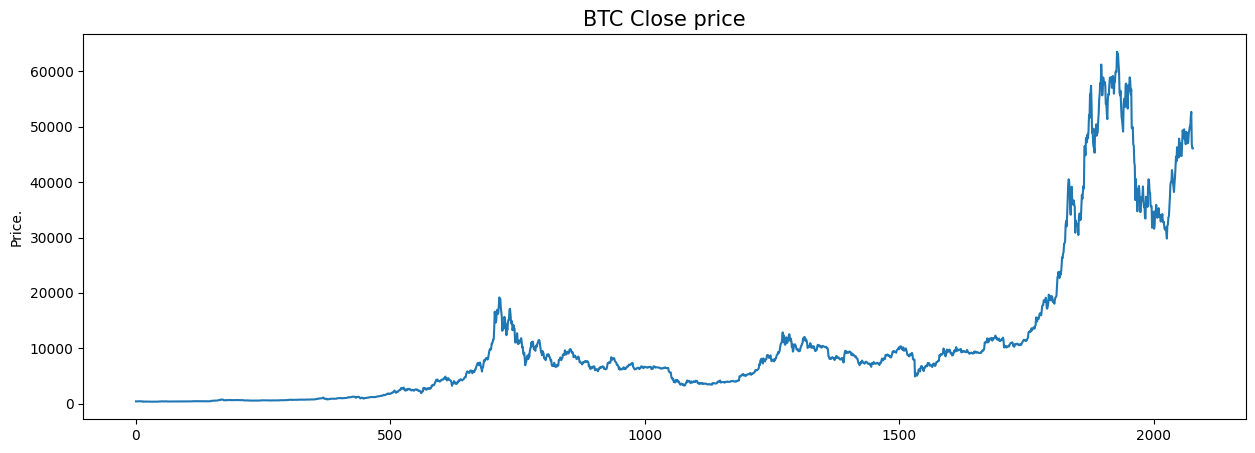

In [39]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('BTC Close price', fontsize=15)
plt.ylabel('Price.')
plt.show()

Bitcoin là dữ liệu về chuỗi giá nên không dừng, mean và stdv thay đổi lớn, phải đưa về cơ số tự nhiên (log) và tính return

In [40]:
df['log_close'] = np.log(df['Close'])
return_btc = []
for i in range(0, len(df['log_close'])-1):
    diff = df['log_close'][i+1] - df['log_close'][i]
    return_btc.append(diff)
return_btc = pd.DataFrame(return_btc)

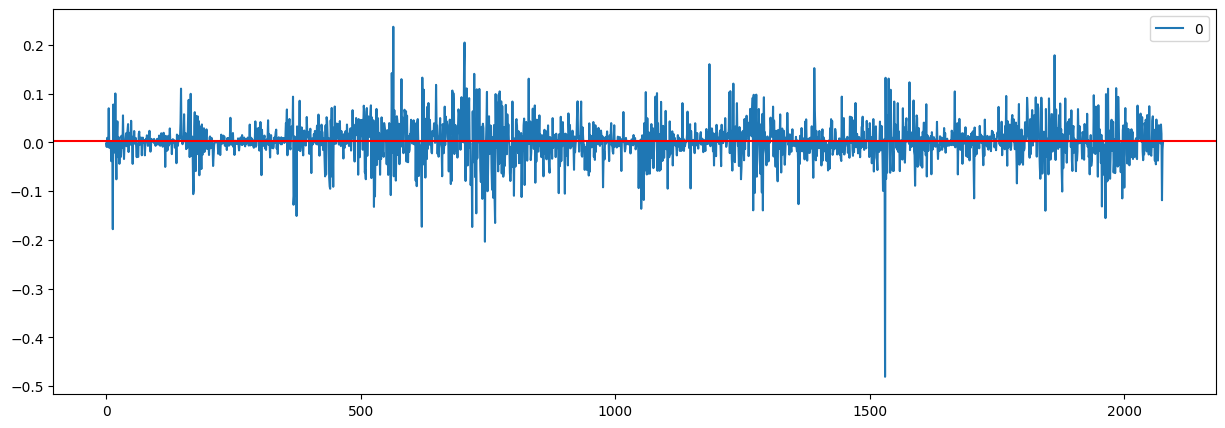

(-31.684731533072565,
 0.0,
 1,
 2075,
 {'1%': -3.433505377391427,
  '5%': -2.862933903509104,
  '10%': -2.567512049992742},
 -7299.683393013078)

In [41]:
return_btc.plot(figsize=(15,5))
plt.axhline(y = np.nanmean(return_btc), label='mean return', c='red')
plt.show()
# Kết hợp Dickey fuller test về tính dừng
adfuller(return_btc)

### Nhận xét:
Cặp kiểm định   H0: Chuỗi trên không có tính dừng\
----------------   H1: Chuỗi trên có tính dừng 
- T-test = -31.68
- P-value = 0.0 >0.05 --> Bác bỏ H0

In [42]:
return_btc.describe()

,0
count,2077.00000
mean,0.00225
std,0.04099
min,-0.48095
25%,-0.01392
50%,0.00196
75%,0.01917
max,0.23716


In [43]:
return_btc.median()

0   0.00196
dtype: float64

In [44]:
return_btc.skew()

0   -0.84522
dtype: float64

In [36]:
return_btc.kurt()

0   12.07798
dtype: float64

### Nhận xét:
- Mean và median của btc xấp xỉ giá trị nhau = 0.002
- Skewness không bằng 0
- Độ lệch biến động lớn (4%/ngày)
- Kurtosis  = 12 --> rất lớn

<Figure size 1500x800 with 0 Axes>

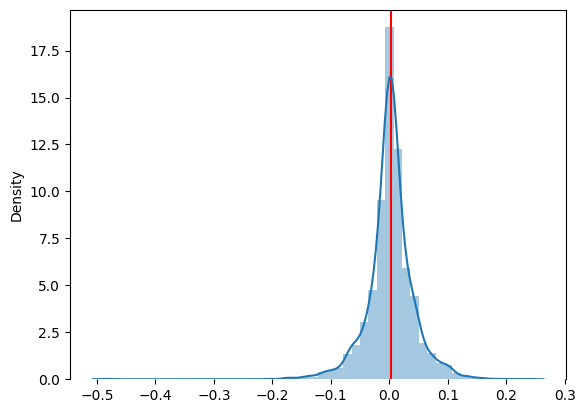

In [45]:
plt.figure(figsize= (15,8))

fig, ax = plt.subplots()
plt.axvline(x= np.nanmean(return_btc), label='mean return', c='red')

sns.distplot(return_btc)
ax.spines['bottom'].set_visible(False)

plt.show()

Phân phối có kéo dài, đuôi to --> maximum likelihood\
(Có thể sử dụng Jarque Bera về sự phân phối)

<Figure size 800x600 with 0 Axes>

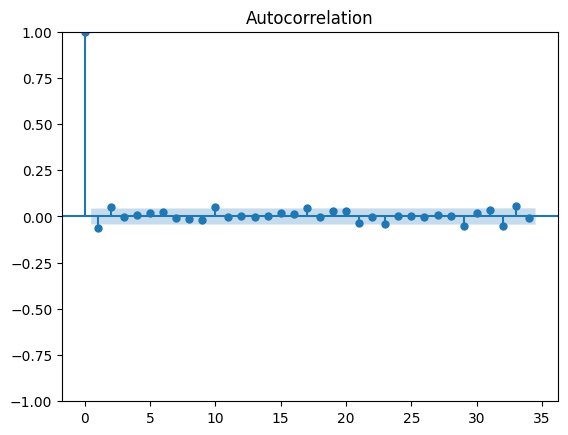

In [46]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(return_btc)

<Figure size 800x600 with 0 Axes>

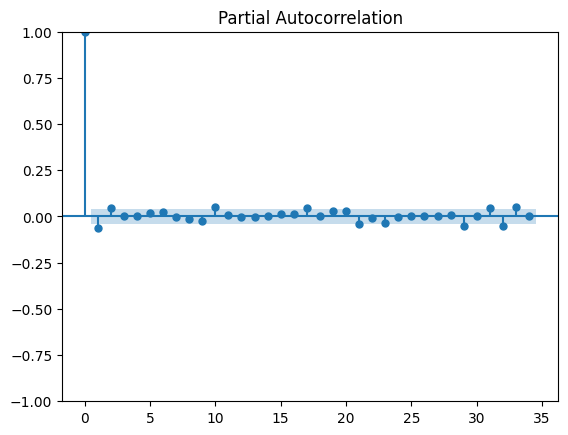

In [47]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(return_btc)

### Nhận xét:
- Tự tương quan của ngày hôm nay bị chịu ảnh hưởng bởi 2 ngày trước đó, còn lại đa số nằm trong khung xanh --> không chịu ảnh hưởng
- Nên lập mô hình AR có tự tương quan =<2

In [48]:
from pmdarima.arima import auto_arima 
model_ar = auto_arima(return_btc,start_p=0, start_q=0,
                           max_p=2, max_q=0,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model_ar.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7367.815, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7373.459, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7376.628, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7381.031, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7378.515, Time=0.21 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.012 seconds
-7381.03115218451


In [49]:
model_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2077
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3694.516
Date:                Sat, 25 Mar 2023   AIC                          -7381.031
Time:                        11:29:56   BIC                          -7358.476
Sample:                             0   HQIC                         -7372.765
                               - 2077                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0023      0.001      2.472      0.013       0.000       0.004
ar.L1         -0.0609      0.016     -3.782      0.000      -0.092      -0.029
ar.L2          0.0466      0.019      2.437      0.015       0.009       0.084
sigma2         0.0017      2e-05     83.254      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13050.73
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Nhận xét:
- Các hệ số Coef các biến trễ L1, L2 có hệ số p value < 0.05 --> có ý nghĩa thống kê ở mức 5%
- Do phần dư là cú sốc thông tin và phải đến thị trường mới hoàn toàn ngẫu nhiên --> Phân phối của phần dư là phân phối(0,1). Có pvalue Jarque-bera = 0.00 --> phân phối phần dư là chuẩn. Giả định là đúng.

In [52]:
df = pd.read_csv(r'E:\learn st new\time series model\btc_usd bitfinex.csv', parse_dates=['Date'])
# df[['Month', 'Day', 'Year']] = df['Date'].str.split("/",n=2, expand = True)

In [53]:
df.Date = pd.to_datetime(df.Date)
df['quarter'] = pd.PeriodIndex(df.Date, freq='Q')


In [54]:
df['log_close'] = np.log(df['Price'])
return_btc = []
for i in range(0, len(df['log_close'])-1):
    diff = df['log_close'][i+1] - df['log_close'][i]
    return_btc.append(diff)
return_btc = pd.DataFrame(return_btc)

In [60]:
# Lựa chọn index để chia train test 
df[df.Date == '1/1/2021']

,Date,Price,Open,High,Low,Vol.,Change %,quarter,log_close
1826,2021-01-01,29346,28933,29498,28932,8.33K,1.43%,2021Q1,10.28691


In [61]:
train, test = df[df['Date'].index < 1826 ], df[df['Date'].index >= 1826]
print('train shape: ', train.shape)
print('test shape: ', test.shape)
train.head()

train shape:  (1826, 9)
test shape:  (252, 9)


,Date,Price,Open,High,Low,Vol.,Change %,quarter,log_close
0,2016-01-01,434,429,437,426,12.97K,1.16%,2016Q1,6.07304
1,2016-01-02,433,434,436,430,6.38K,-0.29%,2016Q1,6.07074
2,2016-01-03,429,433,433,422,19.18K,-0.93%,2016Q1,6.06146
3,2016-01-04,433,429,436,427,13.02K,0.99%,2016Q1,6.07074
4,2016-01-05,432,433,435,428,11.22K,-0.24%,2016Q1,6.06843


In [121]:
model_arma = auto_arima(train['log_close'], order = (2,0,0), seasonal=False, stepwise=True)

In [128]:
# dự đoán xu hướng cho tập test
y_pred = model_arma.predict(n_periods= 252)
y_pred.shape

(252,)

In [127]:
y = test['log_close']

In [130]:
def _measure_metric(y, y_pred):
  e = y-y_pred
  mse=np.mean(e**2)
  rmse=np.sqrt(mse)
  mae=np.mean(np.abs(e))
  mape=np.mean(e/y)

  print('Mean Square Error: {}'.format(mse))
  print('Root Mean Square Error: {}'.format(rmse))
  print('Mean Absolute Error: {}'.format(mae))
  print('Mean Absolute Percentage Error: {}'.format(mape))
  return mse, rmse, mae, mape

In [131]:
mse, rmse, mae, mape=_measure_metric(y, y_pred)

Mean Square Error: 0.09290725392014246
Root Mean Square Error: 0.3048069125202748
Mean Absolute Error: 0.2577325467614899
Mean Absolute Percentage Error: 0.010384274424246746


### Kết quả:
- Biên độ giao động của giá trị dự báo xung quanh giá trị thực bằng 0.304 đv
- Trung bình sai số giữa giá trị dự báo và giá trị thực tế là 0.25 đv
- Sai số của giá trị dự báo so với thực tế vào khoảng xấp xỉ 1%